### 데이터 타입 기록###
A. 데이터 설명

본 대회에서는 한국수력원자력(주)에서 제공받은 원자력 발전소 모사 데이터 및 실제 데이터가 제공됩니다. 

주어진 10분 사이에 발전소의 상태가 변하며 변하기 전 발전소 상태를 상태_A, 변한 후 상태를 상태_B라고 할 때 

데이터를 기반으로 상태_B를 판단하는 것이 대회의 목적입니다. 모든 데이터는 같은 상태 (상태_A)에서 시작합니다. 



모사 데이터는 0초에서 15초 사이에 상태가 변하기 시작합니다. 모든 데이터가 숫자로 이루어져 있습니다. 

반면 실제 데이터는 10초에 상태가 변하기 시작합니다. 실제 데이터에는 Bad, CLOSE, Equip Fail, No Data, Normal, OFF, ON, OPEN, System.Char[] 등 문자열 데이터를 포함하고 있으며 결측치가 있을 수 있습니다. 



훈련 데이터로는 10분 데이터가 주어지며 테스트 데이터로는 1분 간 데이터가 주어집니다. 즉 1분 데이터만 사용하여 평가합니다. 



B. 파일 설명

1. train.zip(9.81GB) : 훈련 데이터가 포함된 zip 파일입니다.

2. test.zip(879MB) : 테스트 데이터가 포함된 zip 파일입니다.

   train.zip, test.zip 내 파일이름은 해당되는 고유한 번호 (id) 로 되어 있습니다. train과 test의 id는 중복되지 않습니다.

3. train_label.csv(6.78KB) : 훈련데이터의 id (파일 이름)에 해당되는 상태_B를 정리한 파일입니다. 

4. sample_submission.csv(283KB) : 제출 형식과 동일한 샘플 데이터 입니다.

5. additional_data.zip(13.9MB) : 실제 발전소 운전 데이터 입니다. 참고자료로 주어지는 파일입니다. (컬럼은 train 및 test 데이터와 같습니다.)



데이터 파일 컬럼에 대한 설명은 아래와 같습니다.

time : 발전소 운전 경과 시간 입니다. 단위는 초 입니다.

V0000~V5120 : 발전소 운영 중 측정되는 변수 입니다. 비식별화 되어 제공됩니다.

O 코드 관련

1) 입상자는 코드 제출 필수. 제출 코드는 예측 결과를 리더보드 점수로 복원할 수 있어야 함

2) 코드 제출시 확장자가 R user는 R or .rmd. Python user는 .py or .ipynb

3) 코드에 ‘/data’ 데이터 입/출력 경로 포함 제출

4) 전체 프로세스를 일목요연하게 정리하여 주석을 포함하여 하나의 파일로 제출

5) 모든 코드는 오류 없이 실행되어야 함(라이브러리 로딩 코드 포함되어야 함).

6) 코드와 주석의 인코딩은 모두 UTF-8을 사용하여야 함 

## metric
평가 지표는 Log Loss를 사용합니다.

In [107]:
import numpy as np
import pandas as pd

from NU_utils import load_eda_statistic_pd,reduce_mem_usage

import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import dill as pickle

from multiprocessing import Pool 
import multiprocessing
from data_loader import data_loader #data_loader.py 파일을 다운 받아 주셔야 합니다. 
from tqdm import tqdm
from functools import partial

from sklearn.model_selection import train_test_split

In [108]:
pd.set_option("display.precision", 15)
np.set_printoptions(suppress=True)

In [109]:
train = pd.read_csv("data/train/0.csv")
target = pd.read_csv("data/train_label.csv")
test = pd.read_csv("data/test/829.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")
print("{} observations and {} features in {} train set.".format(train.shape[0],train.shape[1], len(os.listdir("data/train"))))
print("{} observations and {} features in {} test set.".format(test.shape[0],test.shape[1],len(os.listdir("data/test"))))
print("train : test row ratio {} and file {}".format(train.shape[0] / test.shape[0], len(os.listdir("data/train"))/len(os.listdir("data/test"))))

600 observations and 5122 features in 829 train set.
60 observations and 5122 features in 720 test set.
train : test row ratio 10.0 and file 1.1513888888888888


### Issue:
- column 수 많음 -> 과적합
- train 을 모델에 어떻게 넣을 것인지  
ex1) train 파일 827개 붙이기  
ex2) 600 개마다 압축해서 1개씩 row추출 -> new dataset 만들기 shape(827, 1)  
- train, test 분포 같은지 확인  


In [110]:
target.head()

,id,label
0,0,110
1,1,29
2,2,111
3,3,176
4,4,130


In [111]:
train.head()

,time,V0000,V0001,V0002,V0003,V0004,V0005,V0006,V0007,V0008,...,V5111,V5112,V5113,V5114,V5115,V5116,V5117,V5118,V5119,V5120
0,0,30.486805514842338,8.682229709860227,8.736398910338401,8.691251076945651,8.711798339169684,204.576460623191906,201.196817649585427,-1.213967078312627e-19,0.0,...,1.0,1.0,1.0,1.0,60.0,127.579999999999998,112.263000000000005,-0.264702541577738,85.400000000000006,-0.00447415
1,1,30.460030037987185,8.784153357569387,8.691244152848498,8.706254149779934,8.716142510501294,194.222394536624648,169.979333039524050,-2.279681127678960e-19,0.0,...,1.0,1.0,1.0,1.0,60.0,0.000000000000000,0.000000000000000,0.000014497079589,85.400000000000006,0.00000000
2,2,30.475103338414659,8.812021652543272,8.697733382050595,8.721916599896808,8.681360887686026,193.078138847674495,160.719360406318742,-1.586759552327990e-19,0.0,...,1.0,1.0,1.0,1.0,60.0,0.000000000000000,0.000000000000000,-0.000012976989345,85.400000000000006,0.00000000
3,3,30.455413062677778,8.908323232851204,8.712004219791265,8.723829259947346,8.724655165932754,207.644178077476766,232.675872694281566,-4.016422511668063e-19,0.0,...,1.0,1.0,1.0,1.0,60.0,0.000000000000000,0.000000000000000,0.000019206433100,85.400000000000006,0.00000000
4,4,30.472642226216010,8.815619533760145,8.702881894087803,8.722938992806702,8.702340739541391,186.112451151374728,160.829340162648720,8.676680433001273e-19,0.0,...,1.0,1.0,1.0,1.0,60.0,0.000000000000000,0.000000000000000,-0.000008471765777,85.400000000000006,0.00000000


### 정리
- 5121개의 column이 Anonymized 된 binary classifiacation, multivarate timeseries  


### 문제 정의
- 5121개의 column이 Anonymized 된 Multiclass classification, 
- 0 ~ 15초 사이에 상태가 B로 변함 B의 종류는 198 가지
- B의 종류를 판단하는 것이 목표  
모든 변수가 timeseries인 상태, iid 기반 모델 사용불가, 중요 변수를 어떻게 선택할지
- 5122개의 column / 600 * 827 개의 row 
- train , test 는 모사데이터 => 인공 데이터인경우 정규분포 기반 모델 잘통함 QDA, GMM 등등

In [112]:
train.info()
print("\n")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Columns: 5122 entries, time to V5120
dtypes: float64(5121), int64(1)
memory usage: 23.4 MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Columns: 5122 entries, time to V5120
dtypes: float64(5121), int64(1)
memory usage: 2.3 MB


- int 인 변수들도 float으로 되어 있음 => 정리 필요

In [113]:
eda = load_eda_statistic_pd("eda.pkl",train)

In [114]:
eda["isnull_table"].sum(axis=0)

0

- 모든 column 결측치 없음

In [115]:
#train,_ = reduce_mem_usage(train,False)

In [116]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Columns: 5122 entries, time to V5120
dtypes: float64(5121), int64(1)
memory usage: 23.4 MB



- 소수 : 32개
- -127 ~ 128 : 23개
- 128 이상 자연수 : 8개
- 0 ~ 255 : 2657개

### Y부터 분석

In [117]:
target["label"]

0      110
1       29
2      111
3      176
4      130
      ... 
823     19
824    166
825    132
826     84
827    110
Name: label, Length: 828, dtype: int64

In [118]:
target["label"].describe()

count    828.000000000000000
mean      98.057971014492750
std       53.433469774381571
min        0.000000000000000
25%       54.000000000000000
50%      111.000000000000000
75%      130.000000000000000
max      197.000000000000000
Name: label, dtype: float64

In [119]:
target["label"].value_counts()

110    24
17     21
114    20
118    20
113    19
       ..
134     1
135     1
137     1
138     1
98      1
Name: label, Length: 198, dtype: int64

### ISSUE
- B로 상태가 변하는 시점을 알 필요가 있을까?
- 상태 A인 0 ~ 15초, 상태 B인 15 ~ 600초 어떤 데이터를 사용해야할까?
    - 일단 변수들이 급격하게 변하는 구간을 찾고 그 부분을 전을 A, 이후를 B로 라벨링해서 새로운 변수를 만든 다음에 모델에 넣어보자  
    => 변수 급격하게 변하는 구간 못찾겠다  
    => 일단 15초 다 날리고 시작
- training set 구성할 때 그러면 600개의 데이터를 모두 라벨에 해당하는 값을 y값으로 넣고 827개를 합친다음에 데이터 구성?

### DATA 구성
1. 상태 B의 종류를 판단하려면 0 ~ 15초인 상태 A의 상태가 중요하다  
   따라서 15~600 데이터를 날린다  
2. 상태 B의 종류를 판단하려면 15 ~ 600초인 상태 B의 상태가 중요하다
3. 상태 B의 종류를 판단하려면 상태 A, B 상태 둘다 중요하다, 따라서 최대한 변화시점을 찾아 구분하여 데이터를 살린다

### EDA
0~20 초 사이 데이터만 뽑아서 plotting

In [120]:
from sklearn.preprocessing import StandardScaler

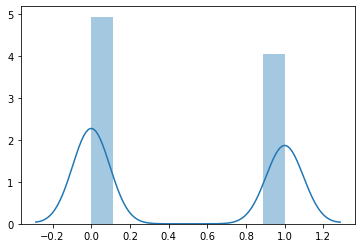

In [121]:
col = train.columns
scaler = StandardScaler()

scaled_train = scaler.fit_transform(train)
scaled_train = pd.DataFrame(scaled_train, columns = col)
sns.distplot(scaled_train.std())

### Line chart 정리
- 눈으로 봐서는 상태가 바뀌는 구간을 찾기 쉽지 않음
- Peak를 찾는 여러 방법을 동원해야할듯 => 나중에

## 2번 의견 모델링

### training set 만들기
상태 B가 중요하므로 상태 A (1초 ~ 15초) 데이터는 삭제  
obs 마다 y가 필요하므로 training label 을 row 마다 반복하여 삽입  
상태 B의 데이터를 보고 Y의 종류를 판단하는 multiclass classification 이며 y 가 시간 t에 의존하지 않으므로 각 상태를 iid로 봐도 됨  
=> 828개 데이터를 모두 merge  
Test data 예측시에도 동일하게 1초 ~ 15초를 날린다음 나머지 45개 데이터에 대해 예측한 뒤 확률들을 평균  

In [122]:
def data_loader_all(func, path, train, nrows, **kwargs):
    '''
    Parameters:
    
    func: 하나의 csv파일을 읽는 함수 
    path: [str] train용 또는 test용 csv 파일들이 저장되어 있는 폴더 
    train: [boolean] train용 파일들 불러올 시 True, 아니면 False
    nrows: [int] csv 파일에서 불러올 상위 n개의 row 
    lookup_table: [pd.DataFrame] train_label.csv 파일을 저장한 변수 
    event_time: [int] 상태_B 발생 시간 
    normal: [int] 상태_A의 라벨
    
    Return:
    
    combined_df: 병합된 train 또는 test data
    '''
    
    # 읽어올 파일들만 경로 저장 해놓기 
    files_in_dir = os.listdir(path)
    
    files_path = [path+'/'+file for file in files_in_dir]
    
    if train :
        func_fixed = partial(func, nrows = nrows, train = True, lookup_table = kwargs['lookup_table'], event_time = kwargs['event_time'], normal = kwargs['normal'])
        
    else : 
        func_fixed = partial(func, nrows = nrows, train = False)
    
    
    # 여러개의 코어를 활용하여 데이터 읽기 Q
    if __name__ == '__main__':
        pool = Pool(processes = multiprocessing.cpu_count()) 
        df_list = list(tqdm(pool.imap(func_fixed, files_path), total = len(files_path)))
        pool.close()
        pool.join()
    
    # 데이터 병합하기 
    combined_df = pd.concat(df_list, ignore_index=True)
    
    return combined_df

In [201]:
if "checkpoint1.pkl" not in os.listdir():
    train_path = 'data/train'
    test_path = 'data/test'
    label = pd.read_csv('data/train_label.csv')
    train = data_loader_all(data_loader, path = train_path, train = True, 
                            nrows = 60, normal = 999, event_time = 15, lookup_table = label)
    test = data_loader_all(data_loader, path = test_path, train = False, nrows = 60)
    
    train_isnull_table = train.isnull().sum(axis = 0)
    test_isnull_table = test.isnull().sum(axis = 0)
    
    train, tr_na,_ = reduce_mem_usage(train,False)
    test, te_na,_ = reduce_mem_usage(test,False)

    data = {"log" : "앞 60개뽑음\nNA처리 -99999 \ntrain,test 용량줄임 ",
            "train" : train,
            "tr_isna" : train_isnull_table,
            "tr_na" : tr_na,
            "test" : test,
            "te_na" : te_na,
            "te_isna" : test_isnull_table}

    with open("checkpoint1.pkl","wb") as f:
        pickle.dump(data,f)
else:
    with open('checkpoint1.pkl', 'rb') as f:
        data = pickle.load(f)
    train = data["train"]; del data["train"]
    test = data["test"]; del data["test"]
    
    tr_na = data["tr_na"]; del data["tr_na"]
    te_na = data["te_na"]; del data["te_na"]
   
    train_isnull_table = data["tr_isna"]; del data["tr_isna"]
    test_isnull_table = data["te_isna"] ; del data["te_isna"]
    
    del data

In [124]:
train.info()
print("\n")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49680 entries, 0 to 49679
Columns: 5124 entries, id to label
dtypes: float32(2431), int8(2), object(1026), uint16(3), uint8(1662)
memory usage: 928.7+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Columns: 5123 entries, id to V5120
dtypes: float32(2390), object(1112), uint16(2), uint8(1619)
memory usage: 827.2+ MB


# ㅁ데이터 클리닝
train set과 test 셋의 분포를 일치시켜 test 셋을 대변할 수 있는 validation set을 만든다
값 하나만 있는 columns 제거 함수는 맨 마지막에 해야한다

### NA처리?

### 1. 0~15 초 데이터 제거

In [232]:
train = train[train["time"] >= 15]
test = test[test["time"] >= 15]

In [233]:
train = train.reset_index(drop = True);train

,id,time,V0000,V0001,V0002,V0003,V0004,V0005,V0006,V0007,...,V5112,V5113,V5114,V5115,V5116,V5117,V5118,V5119,V5120,label
0,0,15,30.469573974609375,8.722738265991211,8.686953544616699,8.677700996398926,8.696934700012207,215.779129028320312,148.857101440429688,-8.951266497848112e-20,...,1.0,1.0,1.0,60.0,0.0,0.0,-0.000002988467259,85.400000000000006,0.0,110
1,0,16,30.471422195434570,8.843732833862305,8.724614143371582,8.736647605895996,8.724141120910645,189.935531616210938,186.819259643554688,5.018470655158951e-19,...,1.0,1.0,1.0,60.0,0.0,0.0,0.000011363270460,85.400000000000006,0.0,110
2,0,17,30.465795516967773,8.639923095703125,8.693429946899414,8.706842422485352,8.698667526245117,167.172012329101562,227.642578125000000,5.601811347828417e-19,...,1.0,1.0,1.0,60.0,0.0,0.0,0.000001157871111,85.400000000000006,0.0,110
3,0,18,30.451257705688477,8.643156051635742,8.721100807189941,8.677412033081055,8.697360038757324,190.645980834960938,181.005096435546875,4.328276321923533e-19,...,1.0,1.0,1.0,60.0,0.0,0.0,0.000004229166734,85.400000000000006,0.0,110
4,0,19,30.469449996948242,8.786702156066895,8.718486785888672,8.632532119750977,8.686937332153320,208.447021484375000,202.666961669921875,3.835714824072640e-19,...,1.0,1.0,1.0,60.0,0.0,0.0,0.000001503047770,85.400000000000006,0.0,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37255,99,55,30.476522445678711,8.680374145507812,8.689265251159668,8.666723251342773,8.714446067810059,209.257888793945312,212.384567260742188,6.307583042961857e-19,...,1.0,1.0,1.0,60.0,0.0,0.0,-0.000019733222871,85.400000000000006,0.0,156
37256,99,56,30.464994430541992,8.818354606628418,8.688116073608398,8.699016571044922,8.719074249267578,233.122680664062500,260.248413085937500,-2.693598634975001e-19,...,1.0,1.0,1.0,60.0,0.0,0.0,-0.000008723241081,85.400000000000006,0.0,156
37257,99,57,30.483489990234375,8.737560272216797,8.706526756286621,8.712057113647461,8.656740188598633,260.322357177734375,201.468826293945312,3.863358941650221e-19,...,1.0,1.0,1.0,60.0,0.0,0.0,0.000001463298531,85.400000000000006,0.0,156
37258,99,58,30.459608078002930,8.696491241455078,8.685299873352051,8.719814300537109,8.698853492736816,232.156921386718750,242.729156494140625,2.594330240626161e-19,...,1.0,1.0,1.0,60.0,0.0,0.0,0.000015405124941,85.400000000000006,0.0,156


In [234]:
test = test.reset_index(drop = True);test

,id,time,V0000,V0001,V0002,V0003,V0004,V0005,V0006,V0007,...,V5111,V5112,V5113,V5114,V5115,V5116,V5117,V5118,V5119,V5120
0,1000,15,30.482568740844727,8.693302154541016,8.713093757629395,8.723855018615723,8.727581977844238,189.843292236328125,202.055999755859375,7.194429227074100e-20,...,1,1,1,1,60,0.0,0.0,0.000019882625566,85.4,0.0
1,1000,16,30.477876663208008,8.616256713867188,8.692724227905273,8.710759162902832,8.714579582214355,197.856857299804688,191.019485473632812,-4.742329332355194e-19,...,1,1,1,1,60,0.0,0.0,0.000012732223695,85.4,0.0
2,1000,17,30.454423904418945,8.667014122009277,8.720491409301758,8.719437599182129,8.685649871826172,215.295806884765625,233.340148925781250,3.681454170131568e-19,...,1,1,1,1,60,0.0,0.0,-0.000004496131169,85.4,0.0
3,1000,18,30.488315582275391,8.687759399414062,8.698545455932617,8.724089622497559,8.703798294067383,218.988174438476562,237.224792480468750,1.390858834321196e-19,...,1,1,1,1,60,0.0,0.0,-0.000008796932889,85.4,0.0
4,1000,19,30.502410888671875,8.787985801696777,8.712785720825195,8.692478179931641,8.695180892944336,187.063690185546875,246.580123901367188,-1.888277304084453e-19,...,1,1,1,1,60,0.0,0.0,0.000009099097042,85.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32395,999,55,30.462764739990234,8.636107444763184,8.717539787292480,8.714714050292969,8.673676490783691,209.395248413085938,221.627227783203125,-5.455287676048071e-19,...,-999,-999,-999,-999,-999,0.0,0.0,-0.000001716861107,-999,0.0
32396,999,56,30.486345291137695,8.687651634216309,8.662559509277344,8.723881721496582,8.720834732055664,193.784896850585938,209.822570800781250,-2.096920171916000e-19,...,-999,-999,-999,-999,-999,0.0,0.0,-0.000004809226084,-999,0.0
32397,999,57,30.471584320068359,8.658864974975586,8.692841529846191,8.704296112060547,8.719989776611328,172.802612304687500,211.979034423828125,1.417866539814994e-19,...,-999,-999,-999,-999,-999,0.0,0.0,0.000006015460258,-999,0.0
32398,999,58,30.464906692504883,8.784168243408203,8.716839790344238,8.723630905151367,8.734382629394531,176.388595581054688,158.344650268554688,-5.953593167771320e-19,...,-999,-999,-999,-999,-999,0.0,0.0,0.000003476302709,-999,0.0


### 2. 문자열처리
    - 30번째 파일 580개의 row는 String 값을 가지고 있음
    - 나머지 다른 row 들은 모두 다 같은 경우가 많음
    - test set 에도 String 값이 있는 데이터가 있다면 -> label 73 맵핑
    => 73 이 아닐수도 있으니까 -999 맵핑
    
    - test set 에는 String 값이 있는 데이터가 없다면 -> 
        - 그 column의 값의 종류가 String 값을 제외하고 한개 밖에 없다면 -> 삭제
        - 값의 종류가 여러개 있다면 -> test set을 보고 결정
 
    - 1번 : 30번째 파일을 다 날린다
    - 2번 : 테스트 셋을 보고 분포를 일치시키는 방향으로 처리한다.

In [235]:
def get_rows_containing_str(df):
    """
    df 내에서 string을 가진 row_index 를 return
    
    args :
        df -- (pd.DataFrame)
        
    return :
        row_index = (pd.Index) 
    """
    containing_str = df.select_dtypes('object')
    str_row_list = []
    for idx in containing_str.index:
        try:
            containing_str.iloc[idx,].astype(np.float64)
        except:
            str_row_list.append(idx)    
    
    return pd.Index(str_row_list)

In [236]:
str_tr_r = get_rows_containing_str(train)
str_tr_c = train.select_dtypes('object').columns

In [237]:
str_te_r = get_rows_containing_str(test)
str_te_c = test.select_dtypes('object').columns

In [239]:
print(len(str_tr_c),len(str_te_c))

0 1112


In [240]:
train.loc[str_tr_r, str_tr_c] = -999

In [241]:
test.loc[str_te_r,str_te_c] = -999

In [242]:
train = train.infer_objects()
test = test.infer_objects()

In [243]:
train.info()
print("\n")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37260 entries, 0 to 37259
Columns: 4306 entries, id to label
dtypes: float32(2422), float64(1026), int8(2), uint16(2), uint8(854)
memory usage: 666.5 MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32400 entries, 0 to 32399
Columns: 4305 entries, id to V5120
dtypes: float32(2381), float64(1112), uint16(1), uint8(811)
memory usage: 594.3 MB


=> 모두 숫자데이터 만듬

### 3. 모든 열이 같은 값을 가지고 있으면 제거 

In [244]:
def get_single_value_col(df):
    """
    df내에서 값의 종류가 하나만 있는 columns을 return

    args :
        df -- (pd.DataFrame) 
        
    return:
        single -- (list) list of single value columns
    """
    single = []
    for col in df.columns:
        if df[col].nunique() == 1:
            single.append(col)
    return single

In [245]:
single = get_single_value_col(pd.concat([train,test],sort = False))

In [246]:
train = train.drop(single,axis = 1)
test = test.drop(single,axis = 1)

In [254]:
filename =  "checkpoint4.pkl"
if filename not in os.listdir():
    data = {"log" : """Adversarial: 1,
            NA처리 -99999 
            문자열 처리 -999
            """,
            "train" : train,
            "test" : test,
            }

    with open(filename,"wb") as f:
        pickle.dump(data,f)
#else:
#    with open('checkpoint2.pkl', 'rb') as f:
#    data = pickle.load(f)
#    train = data["train"]
#    test = data["test"]

### 4. train 과 test set 의 분포 일치시키기

- Adversarial test 결과 train 과 test 셋의 분포가 많이 다르다는 것을 알수 있었으
- feature importance 를 사용해서 10개를 줄여보았으나 큰 차이는 없었음  


- KS test를 사용해서 두 column 이 같은 분포에서 추출되었다는 가설이 기각되지 않을 때만 넣기로 하였음  
- p- value 0.05 로 했더니 2300개가 통과  
  
  
- 그래도 Adversarial test 시에 auc가 0.78 로 높음

In [278]:
temp1 = train.copy()
temp2 = test.copy()
temp1["label"] = 0
temp2["label"] = 1
total = pd.concat([temp1, temp2]).reset_index(drop = True)

### Adversarial Test

In [217]:
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier

In [218]:
total.shape

(69660, 4306)

### 문제점
모델이 train 과 test 를 구분 잘해냄
원인 :
1. 주최측에서 train set과 test set을 뽑을 때 random sampling을 하지 않았을 경우  
2. 1500 개의 train 뭉치 중에서 outlier가 train set에만 많이 있었을경우  
해결책 :   
train과 test가 차이나게 만드는 변수를 없앤다.  
=> test는 잘 예측 못해도 나머지 private data는 잘 예측할 수 도있다  
=> 너무 모험.. 변수 없애는게 타당할듯  
=> 이렇게하니까 정보손실이 너무 크다

0  roc_auc: 0.96094
1  roc_auc: 0.95303
2  roc_auc: 0.94856
3  roc_auc: 0.94552
4  roc_auc: 0.93938
5  roc_auc: 0.93841
6  roc_auc: 0.9343
7  roc_auc: 0.93074
8  roc_auc: 0.92587
9  roc_auc: 0.91561
10  roc_auc: 0.91127
11  roc_auc: 0.90788
12  roc_auc: 0.90583
13  roc_auc: 0.89906
14  roc_auc: 0.8969
15  roc_auc: 0.88972
16  roc_auc: 0.88403
17  roc_auc: 0.87715
18  roc_auc: 0.8767
19  roc_auc: 0.86877
20  roc_auc: 0.85853
21  roc_auc: 0.84901
22  roc_auc: 0.84896
23  roc_auc: 0.83914
24  roc_auc: 0.83203
25  roc_auc: 0.82138
26  roc_auc: 0.81979
27  roc_auc: 0.81122
28  roc_auc: 0.80502
29  roc_auc: 0.80316
30  roc_auc: 0.80029
31  roc_auc: 0.79645
32  roc_auc: 0.79261
33  roc_auc: 0.79081
34  roc_auc: 0.78532
35  roc_auc: 0.78467
36  roc_auc: 0.78589
37  roc_auc: 0.78339
38  roc_auc: 0.77882
39  roc_auc: 0.77623
40  roc_auc: 0.77364
41  roc_auc: 0.76326
42  roc_auc: 0.76444
43  roc_auc: 0.76069
44  roc_auc: 0.75126
45  roc_auc: 0.74977
46  roc_auc: 0.74885
47  roc_auc: 0.74543
48  roc_auc: 0.74424
49  roc_auc: 0.73776
50  roc_auc: 0.73958
51  roc_auc: 0.73855
52  roc_auc: 0.73277
53  roc_auc: 0.7298
54  roc_auc: 0.7301
55  roc_auc: 0.72458
56  roc_auc: 0.72629
57  roc_auc: 0.72368
58  roc_auc: 0.72331
59  roc_auc: 0.71678
60  roc_auc: 0.71766
61  roc_auc: 0.71688
62  roc_auc: 0.71191
63  roc_auc: 0.71905
64  roc_auc: 0.71586
65  roc_auc: 0.71315
66  roc_auc: 0.71408
67  roc_auc: 0.71469
68  roc_auc: 0.71167
69  roc_auc: 0.7043
70  roc_auc: 0.70787
71  roc_auc: 0.70465
72  roc_auc: 0.7065
73  roc_auc: 0.70613
74  roc_auc: 0.70193
75  roc_auc: 0.70169
76  roc_auc: 0.69766
77  roc_auc: 0.70008
78  roc_auc: 0.70015
79  roc_auc: 0.69435
80  roc_auc: 0.69641
81  roc_auc: 0.69394
82  roc_auc: 0.69338
83  roc_auc: 0.69264
84  roc_auc: 0.68355
85  roc_auc: 0.68997
86  roc_auc: 0.68681
87  roc_auc: 0.68832
88  roc_auc: 0.68691
89  roc_auc: 0.68408
90  roc_auc: 0.68527
91  roc_auc: 0.69162
92  roc_auc: 0.68743
93  roc_auc: 0.68458
94  roc_auc: 0.68847
95  roc_auc: 0.68422
96  roc_auc: 0.6839
97  roc_auc: 0.68556
98  roc_auc: 0.68447
99  roc_auc: 0.68482
100  roc_auc: 0.68442
101  roc_auc: 0.68363
102  roc_auc: 0.68204
103  roc_auc: 0.67825
104  roc_auc: 0.67475
105  roc_auc: 0.68392
106  roc_auc: 0.6781
107  roc_auc: 0.67971
108  roc_auc: 0.67617
109  roc_auc: 0.67473
110  roc_auc: 0.67843
111  roc_auc: 0.67934
112  roc_auc: 0.68134
113  roc_auc: 0.6795
114  roc_auc: 0.67787
115  roc_auc: 0.6787
116  roc_auc: 0.67788
117  roc_auc: 0.67913
118  roc_auc: 0.67636
119  roc_auc: 0.68114
120  roc_auc: 0.67909
121  roc_auc: 0.67661
122  roc_auc: 0.68167
123  roc_auc: 0.67749
124  roc_auc: 0.67745
125  roc_auc: 0.67845
126  roc_auc: 0.67757
127  roc_auc: 0.6792
128  roc_auc: 0.6822
129  roc_auc: 0.68111
130  roc_auc: 0.67788
131  roc_auc: 0.68009
132  roc_auc: 0.68138
133  roc_auc: 0.6806
134  roc_auc: 0.68014
135  roc_auc: 0.67476
136  roc_auc: 0.67906
137  roc_auc: 0.67934
138  roc_auc: 0.6811
139  roc_auc: 0.67985
140  roc_auc: 0.679
141  roc_auc: 0.67985
142  roc_auc: 0.67708
143  roc_auc: 0.67504
144  roc_auc: 0.67701
145  roc_auc: 0.678
146  roc_auc: 0.67818
147  roc_auc: 0.6784
148  roc_auc: 0.67764
149  roc_auc: 0.67695
150  roc_auc: 0.67796
151  roc_auc: 0.67907
152  roc_auc: 0.68178
153  roc_auc: 0.67727
154  roc_auc: 0.67808
155  roc_auc: 0.678
156  roc_auc: 0.68095
157  roc_auc: 0.68086
158  roc_auc: 0.67777
159  roc_auc: 0.68258
160  roc_auc: 0.6778
161  roc_auc: 0.67473
162  roc_auc: 0.67975
163  roc_auc: 0.68307
164  roc_auc: 0.68248
165  roc_auc: 0.68182
166  roc_auc: 0.68111
167  roc_auc: 0.68289
168  roc_auc: 0.67744
169  roc_auc: 0.67731
170  roc_auc: 0.67448
171  roc_auc: 0.67885
172  roc_auc: 0.68088
173  roc_auc: 0.67932
174  roc_auc: 0.55779
175  roc_auc: 0.54395
176  roc_auc: 0.54685
177  roc_auc: 0.53542
178  roc_auc: 0.54433
179  roc_auc: 0.52942
180  roc_auc: 0.53659
181  roc_auc: 0.53569
182  roc_auc: 0.53314
183  roc_auc: 0.53408
184  roc_auc: 0.53216
185  roc_auc: 0.53564
186  roc_auc: 0.53357
187  roc_auc: 0.52723
188  roc_auc: 0.5321
189  roc_auc: 0.52864
190  roc_auc: 0.53469
191  roc_auc: 0.52014
192  roc_auc: 0.52384
193  roc_auc: 0.53129
194  roc_auc: 0.52628
195  roc_auc: 0.52783
196  roc_auc: 0.52027
197  roc_auc: 0.52244
198  roc_auc: 0.52586
199  roc_auc: 0.51944
200  roc_auc: 0.52491
201  roc_auc: 0.51666
202  roc_auc: 0.52068
203  roc_auc: 0.52317
204  roc_auc: 0.51896
205  roc_auc: 0.51524
206  roc_auc: 0.51963
207  roc_auc: 0.51813
208  roc_auc: 0.51479
209  roc_auc: 0.51578
210  roc_auc: 0.52103
211  roc_auc: 0.51608
212  roc_auc: 0.51275
213  roc_auc: 0.50801
214  roc_auc: 0.50995
215  roc_auc: 0.50615
216  roc_auc: 0.50597
217  roc_auc: 0.50869
218  roc_auc: 0.51086
219  roc_auc: 0.50426
220  roc_auc: 0.50315
221  roc_auc: 0.50523
222  roc_auc: 0.50778
223  roc_auc: 0.50557
224  roc_auc: 0.50301
225  roc_auc: 0.50394
226  roc_auc: 0.50216
227  roc_auc: 0.50319
228  roc_auc: 0.49802

In [177]:
total = total.drop(['V1745', 'V2186', 'V3535', 'V2832', 'V0972', 'V1443', 'V1756', 'V4079', 'V2834', 'V2166',
                    'V0922', 'V1757', 'V3480', 'V0495', 'V2688', 'V1379', 'V2161', 'V2692', 'V2159', 'V2831',
                    'V2167', 'V2833', 'V1246', 'V2165', 'V2370', 'V4421', 'V2164', 'V4422', 'V0751', 'V4374', 
                    'V0467', 'V2720', 'V2169', 'V1232', 'V2162', 'V4463', 'V3661', 'V2163', 'V3614', 'V4375', 
                    'V1746', 'V3035', 'V2157', 'V2185', 'V4730'], axis = 1)

In [285]:
total.shape

(69660, 1986)

In [178]:
from scipy.stats import ks_2samp
hypothesisnotrejected = []
hypothesisrejected = []

for col in test.columns:
    statistic, pvalue = ks_2samp(train[col], test[col])
    if pvalue>=0.05:
        hypothesisnotrejected.append(col)
    if pvalue<0.05:
        hypothesisrejected.append(col)
        
    #plt.figure(figsize=(8,4))
    #plt.title("Kolmogorov-Smirnov test for train/test\n"
    #          "feature: {}, statistics: {:.5f}, pvalue: {:5f}".format(col, statistic, pvalue))
    #sns.kdeplot(train[col], color='blue', shade=True, label='Train')
    #sns.kdeplot(test[col], color='green', shade=True, label='Test')

    #plt.show()
hypothesisrejected.remove("id")

In [179]:
total = total.drop(hypothesisrejected, axis = 1)

In [271]:
%%time
feature_importance = pd.DataFrame()
features = [c for c in total.columns if c not in ['id','time','label']]
target = total['label']
X_train, X_valid, y_train, y_valid = train_test_split(total[features], target, test_size=0.2, random_state=43)

trn_data = Pool(X_train, y_train)
val_data = Pool(X_valid, y_valid)

model = CatBoostClassifier(task_type = "GPU",
                           devices='0',
                           random_seed = 10,
                           loss_function='MultiClass'
                          )

fit_model = model.fit(trn_data,
                     eval_set = val_data,
                     use_best_model = True,
                     verbose = 500,
                     plot = False)

0:	learn: 0.6856259	test: 0.6856313	best: 0.6856313 (0)	total: 67.5ms	remaining: 1m 7s
500:	learn: 0.3873960	test: 0.3895328	best: 0.3895328 (500)	total: 22.6s	remaining: 22.5s
999:	learn: 0.3321153	test: 0.3408092	best: 0.3408092 (999)	total: 46.1s	remaining: 0us
bestTest = 0.3408092025
bestIteration = 999
Wall time: 1min


In [272]:
p_valid = fit_model.predict_proba(X_valid[features].values)[:,1]
roc_auc = roc_auc_score(y_valid, p_valid)
feature_importance["feature"] = features
feature_importance["importance"] = model.get_feature_importance(val_data,type='LossFunctionChange')
print(f'roc_auc: {roc_auc:.5}')

roc_auc: 0.94373


<Figure size 432x288 with 0 Axes>

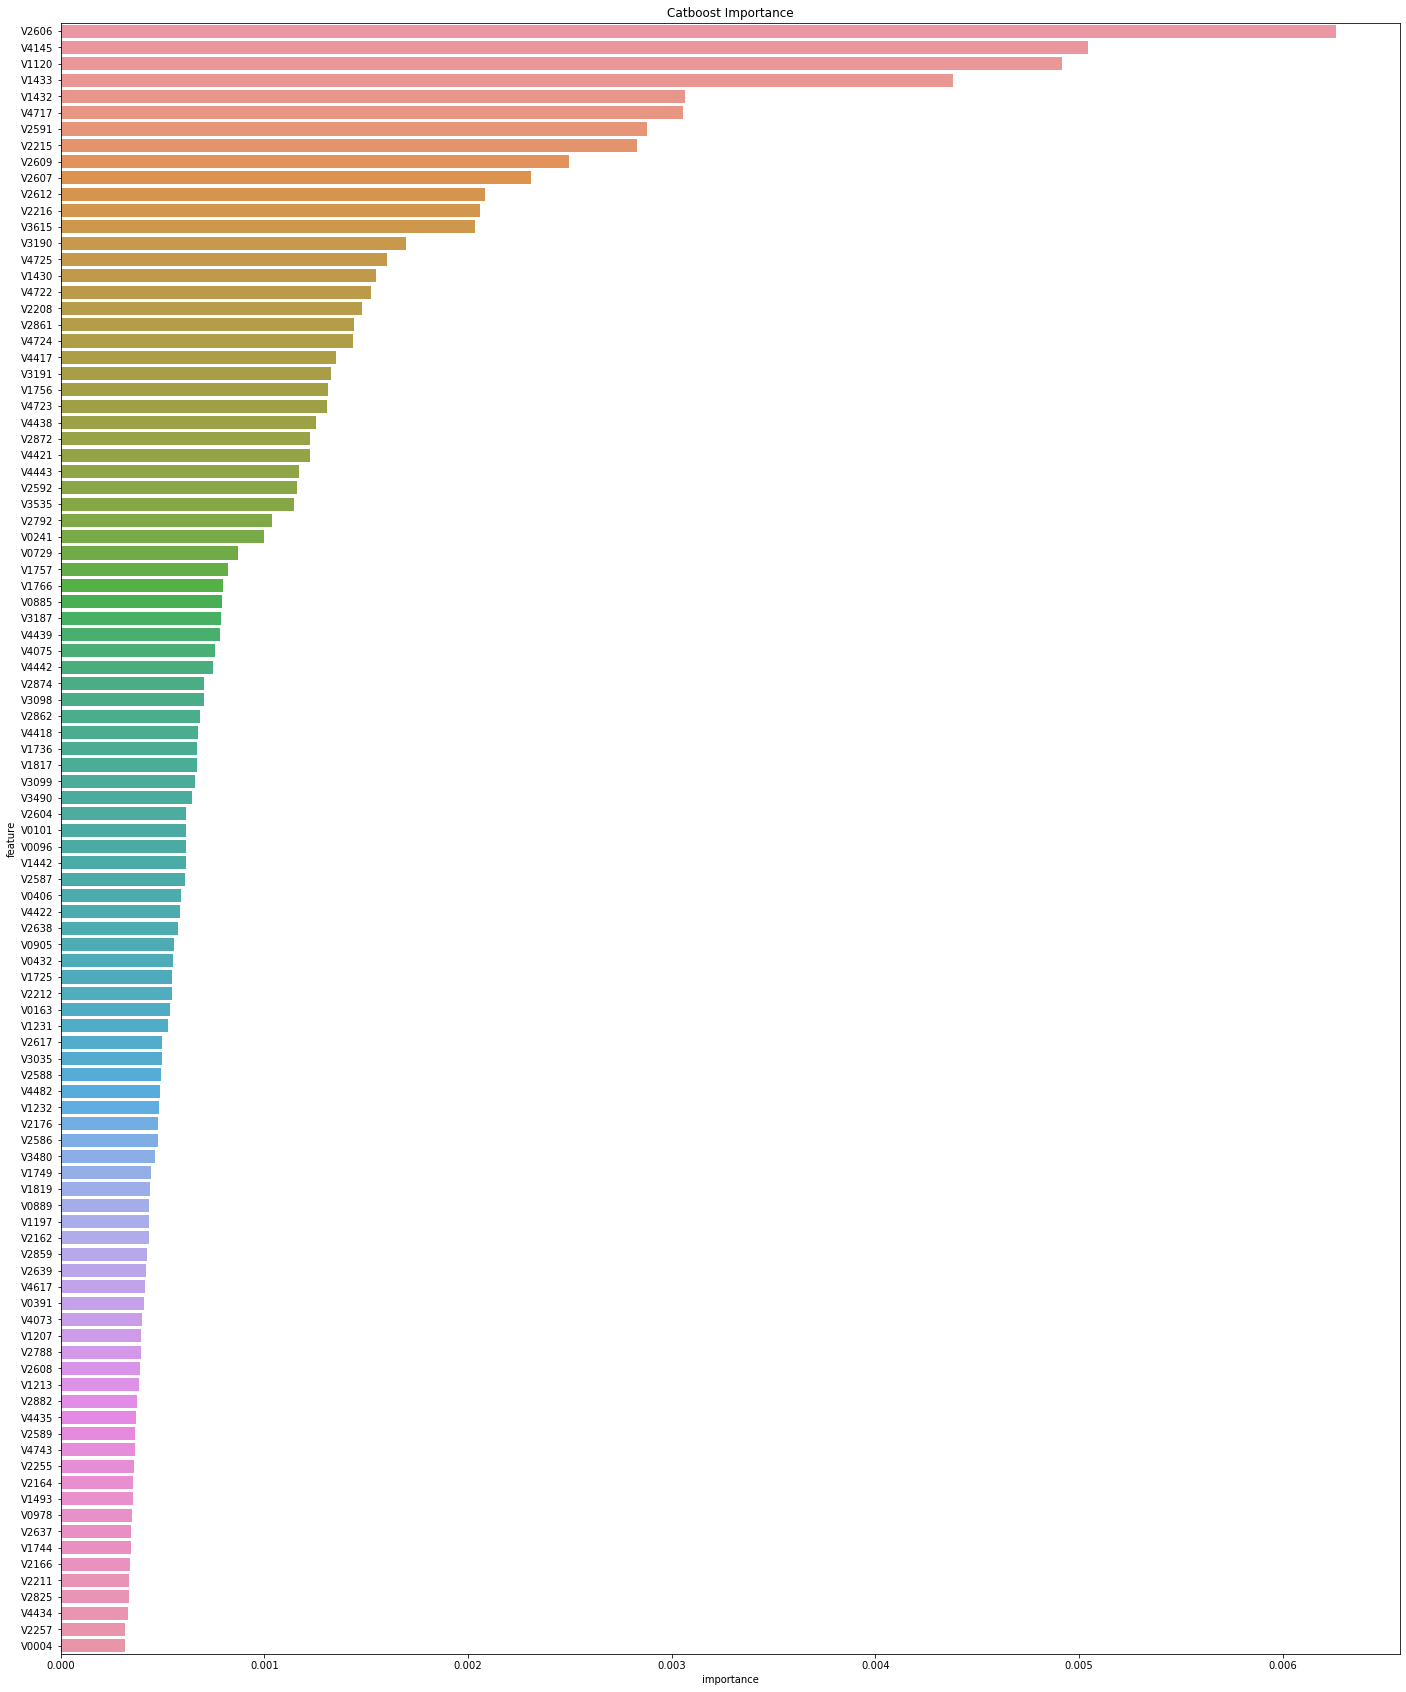

In [273]:
plt.figure()
fig, ax = plt.subplots(figsize=(24,30))
sns.barplot(x="importance", y="feature", data=feature_importance.sort_values(by="importance", ascending=False)[0:100]);
plt.title('Catboost Importance');

In [287]:
drop = drifted_variable[:1740]

['V2801',
 'V4145',
 'V0090',
 'V1431',
 'V3177',
 'V2606',
 'V1436',
 'V2819',
 'V1122',
 'V2881',
 'V2584',
 'V1432',
 'V2781',
 'V3665',
 'V2607',
 'V2900',
 'V3190',
 'V2216',
 'V1430',
 'V3616',
 'V2591',
 'V2609',
 'V2610',
 'V2214',
 'V3615',
 'V2585',
 'V1442',
 'V4719',
 'V2947',
 'V2600',
 'V2612',
 'V2592',
 'V2215',
 'V4720',
 'V2210',
 'V2208',
 'V1245',
 'V1106',
 'V2586',
 'V1121',
 'V2211',
 'V2212',
 'V2213',
 'V1378',
 'V2631',
 'V2638',
 'V2587',
 'V4716',
 'V0884',
 'V2637',
 'V1749',
 'V4717',
 'V2632',
 'V2251',
 'V2589',
 'V2633',
 'V2255',
 'V2176',
 'V1720',
 'V2855',
 'V2854',
 'V2687',
 'V4438',
 'V2257',
 'V2639',
 'V2608',
 'V4723',
 'V4439',
 'V4482',
 'V4441',
 'V4440',
 'V4722',
 'V2792',
 'V2250',
 'V2604',
 'V2691',
 'V4435',
 'V0885',
 'V2082',
 'V1205',
 'V4724',
 'V4434',
 'V2282',
 'V4725',
 'V2248',
 'V2249',
 'V2081',
 'V3187',
 'V4442',
 'V2077',
 'V4443',
 'V2283',
 'V2281',
 'V2588',
 'V2827',
 'V2246',
 'V3535',
 'V2258',
 'V4808',
 'V3191',


In [ ]:
drop_list = []
for var in drop:
    if var not in important[:1740]:
        drop_list.append(var)

In [284]:
with open("drift.pkl","wb") as f:
    pickle.dump(drifted_variable,f)

In [ ]:
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
total.select_dtypes("uint8")
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [106]:
total[total.select_dtypes("uint8").columns[393]].value_counts()

1    69636
0       24
Name: V2527, dtype: int64

In [195]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.metrics import log_loss

In [196]:
df_train = train.copy()
df_test = test.copy()

In [197]:
len_train = len(train)
total = pd.concat([train, test],sort=False).reset_index(drop = True)

In [200]:
train.shape

(37260, 2916)

In [198]:
total = total.drop(['V1745', 'V2186', 'V3535', 'V2832', 'V0972', 'V1443', 'V1756', 'V4079', 'V2834', 'V2166',
                    'V0922', 'V1757', 'V3480', 'V0495', 'V2688', 'V1379', 'V2161', 'V2692', 'V2159', 'V2831',
                    'V2167', 'V2833', 'V1246', 'V2165', 'V2370', 'V4421',], axis = 1)

KeyError: "['V1745' 'V2186' 'V3535' 'V2832' 'V0972' 'V1443' 'V1756' 'V4079' 'V2834'\n 'V2166' 'V0922' 'V1757' 'V3480' 'V0495' 'V2688' 'V1379' 'V2161' 'V2692'\n 'V2159' 'V2831' 'V2167' 'V2833' 'V1246' 'V2165' 'V2370' 'V4421'] not found in axis"

In [ ]:
total = total.drop(hypothesisrejected, axis = 1)

test = total[len_train:]
train = total[:len_train]

In [ ]:
#filename =  "checkpoint3"
if "checkpoint3.pkl" not in os.listdir():
    data = {"log" : """Adversarial: 0.62, KS reject 열삭제
            NA처리 -99999 
            문자열 처리 -999
            """,
            "train" : train,
            "test" : test,
            }

    with open("checkpoint2.pkl","wb") as f:
        pickle.dump(data,f)
#else:
#    with open('checkpoint2.pkl', 'rb') as f:
#    data = pickle.load(f)
#    train = data["train"]
#    test = data["test"]

## 성능 비교&개선 위한 small dataset
1. 빠르면서도 전체 데이터 반영
    => 각 target 라벨마다 stratified subsampling
2. 전체 데이터의 20%만 사용

In [ ]:
_x,X_subtrain, _y, y_subtrain = train_test_split(train[features], target, test_size=0.20, stratify = _y, random_state=42)

#### 2. 30번째 데이터 문자열 처리

ㅁㅇㄴ
train_obj.head()
two_unique_values_col = []
more_unique_values_col = []
for col in train_obj.columns:
    if len(train_obj[col].value_counts().keys()) == 2:
        two_unique_values_col.append(col)
    else:
        more_unique_values_col.append(col)

len(two_unique_values_col)

train[more_unique_values_col[0]].value_counts()

test[more_unique_values_col[0]].value_counts()

train.to_csv("train.csv",index=False)

train_obj = train[train.columns[train.dtypes == object]]

train_obj.iloc[:,1002].value_counts()

580 개의 row가 계속 string 값을 가지고있음
이 580개의 row를 제외하면 문자열을 가진 값 X

str_row_list = []
for i in range(len(train_obj)):
    try:
        train_obj.iloc[i,].astype(np.float64)
    except:
        str_row_list.append(i)

len(str_row_list)

train.iloc[str_row_list,:]